# 전이학습
- 사전 훈련된 모델을 가져온다
- 마지막의 완전연결층 부분을 새로 만든다
- 마지막 층(이미지의 라벨을 결정하는 부분)만 학습한다.


## 전이 학습(transfer learning)의 대표적인 두 가지 시나리오
1. 전체 네트워크를 fine-tuning(미세조정) 하는 방식 
2. 사전학습된(pre-trained) 네트워크를 고정된 특징 추출기(fixed feature extractor)로 사용하는 방식
-> 2번 방식은 앞 층의 가중치를 고정해 기울기를 계산하지 않아 학습속도가 빠르다

* 클래스의 개수가 많은 데이터셋을 이용하는 경우에는 1, 2의 성능 차이가 크게 날 수 있다.
참고 : https://ndb796.tistory.com/552

In [1]:
from google.colab import drive 
drive.mount('/gdrive') # 구글드라이브 연결

Mounted at /gdrive


In [2]:
import zipfile as zf
files = zf.ZipFile("/gdrive/My Drive/Colab Notebooks/onlyimagedata.zip",'r') # 압축 파일의 자료 읽기
files.extractall()
files.close()

In [3]:
# 폴더명 기준으로 라벨 구분
import os

labels = os.listdir(r'/content/data') 
print('라벨:', labels)

라벨: ['pet', 'paper', 'vin', 'styro', 'can', 'plastic']


In [4]:
# 각 라벨마다 train, val 파일 생성 및 데이터 나누기(8대2)
!pip install split-folders

import splitfolders

os.mkdir("/content/data_new")
splitfolders.ratio('/content/data', output="/content/data_new", seed=77, ratio=(0.8, 0.2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 60000 files [00:10, 5938.06 files/s]


In [5]:
!pip install torch
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy
import numpy as np
import time
from torchsummary import summary

cudnn.benchmark = True # 최적의 backend 연산을 찾는 flag를 true 로 설정
plt.ion()   # 대화형 모드

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용가능 여부 확인. cuda가 설정되어 있으면 연산을 gpu로 하고, 아니면 cpu
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


device(type='cuda', index=0)

In [6]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체를 train, val 별로 지정
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),# 이미지 resize 
        transforms.RandomResizedCrop(224), # 이미지를 랜덤으로 자르기
        transforms.RandomHorizontalFlip(),# 데이터 증진(augmentation)
        transforms.ToTensor(), # 데이터를 tensor로 바꿔준다. 넘파이는 정수값이 들어있어 오차율 가늠이 힘들고 CIDA 연산도 지원하지 않음
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화(normalization)작업에 쓰일 각 채널의 표준값과 표준편차값, PyTorch 기본값으로 셋팅
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
data_dir = '/content/data_new' # 이미지 데이터셋에 상단의 transform 내용 적용

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# train과 valid 데이터 개수 확인
print(len(image_datasets['train']), len(image_datasets['val']))

48000 12000


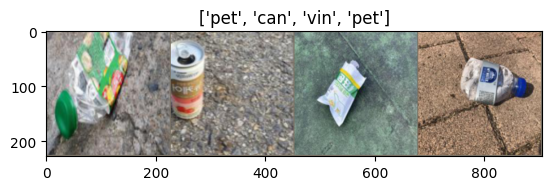

In [9]:
def imshow(inp, title=None): # 이미지 확인용 함수
    # torch.Tensor를 numpy 객체로 변환
    inp = inp.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # 이미지 출력
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes]) #  batch size만큼의 image, label이 출력

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25): # 모델학습 함수
    since = time.time()

    loss_history = {'train': [], 'val': []}  # 그래프 그리기용 
    metric_history = {'train': [], 'val': []}  # 그래프 그리기용

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):  # 에폭마다 for문을 넣어주고
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습단계와 테스트 단계를 거쳐서 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # 아웃풋 설정
                    _, preds = torch.max(outputs, 1) # 인풋에 대현 예측값
                    loss = criterion(outputs, labels) # 예측값과 실제 결과값 비교

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward() # 역전파
                        optimizer.step() # 최적화(optimizer 스텝 증가) 

                # 통계
                running_loss += loss.item() * inputs.size(0) # 교차엔트로피 계산. deafualt값이 mean이므로 각 데이터 마다의 손실 평균이 저장, 배치 사이즈를 곱해줘 한 배치 사이즈의 loss 총합을 계산
                running_corrects += torch.sum(preds == labels.data) # 예측값이 맞은 횟수 더하기
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase] # 에폭에 따른 loss, accuracy 계산 (전체 데이터 loss합/ 각 데이터셋 크기)
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 

            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}') # loss, accuracy 출력

            if phase == 'train':               # 그래프 그리기용
                loss_history['train'].append(epoch_loss)
                metric_history['train'].append(epoch_acc)
            else:
                loss_history['val'].append(epoch_loss)
                metric_history['val'].append(epoch_acc)

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc: # best_acc, weight 값 저장
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since       # 반복할 때마다 현재 - 기존 시간 계산해 걸린 시간 표시
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Accuracy: {best_acc:4f}')

    # 제일 잘 나온 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [11]:
def visualize_model(model, num_images=6): # 시각화 함수
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # 모델에 나온 값
            _, preds = torch.max(outputs, 1) # 예측값

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}') #예측값만 출력
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training) # 앞에서 선언한 값에 넣기
                    return
        model.train(mode=was_training)

In [15]:
from torch.optim import lr_scheduler # 미세조정 (무작위 초기화가 아닌, 미리 학습한 신경망으로 초기화한다)

model_ft = models.resnet34(pretrained=True) # False가 되면 모델의 구조만 가져오고 초깃값은 랜덤 설정
num_ftrs = model_ft.fc.in_features  # fc는 모델의 마지막 layer를, in_features는 해당 층의 입력 채널 수 반환

# 여기서 각 출력 샘플의 크기를를 nn.Linear(num_ftrs, len (class_names))로 일반화
model_ft.fc = nn.Linear(num_ftrs, len (class_names)) # 512, 6(라벨 수에 맞춰야 함함)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 곱해서 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [16]:
summary(model_ft, (3,32,32)) # 모델 정보 확인

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [17]:
model_ft, loss_hist, metric_hist = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10) 

Epoch 0/9
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.7940 Accuracy: 0.7230
val Loss: 0.4248 Accuracy: 0.8560

Epoch 1/9
----------
train Loss: 0.5172 Accuracy: 0.8189
val Loss: 0.4527 Accuracy: 0.8413

Epoch 2/9
----------
train Loss: 0.4346 Accuracy: 0.8470
val Loss: 0.4196 Accuracy: 0.8491

Epoch 3/9
----------
train Loss: 0.3996 Accuracy: 0.8579
val Loss: 0.3155 Accuracy: 0.8917

Epoch 4/9
----------
train Loss: 0.3698 Accuracy: 0.8674
val Loss: 0.2784 Accuracy: 0.9062

Epoch 5/9
----------
train Loss: 0.3418 Accuracy: 0.8767
val Loss: 0.2559 Accuracy: 0.9122

Epoch 6/9
----------
train Loss: 0.3307 Accuracy: 0.8817
val Loss: 0.2615 Accuracy: 0.9071

Epoch 7/9
----------
train Loss: 0.2429 Accuracy: 0.9124
val Loss: 0.1883 Accuracy: 0.9372

Epoch 8/9
----------
train Loss: 0.2174 Accuracy: 0.9198
val Loss: 0.1839 Accuracy: 0.9372

Epoch 9/9
----------
train Loss: 0.2090 Accuracy: 0.9249
val Loss: 0.1755 Accuracy: 0.9401

Training complete in 95m 5s
Best val Accuracy: 0.940083


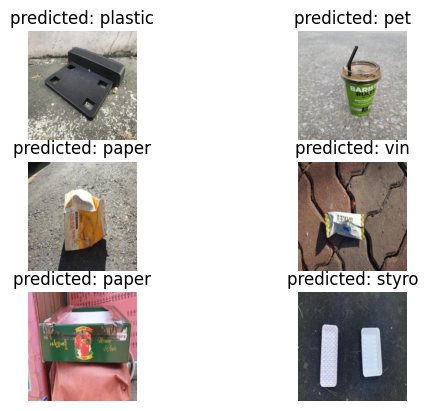

In [18]:
visualize_model(model_ft) # 예측값 시각화 

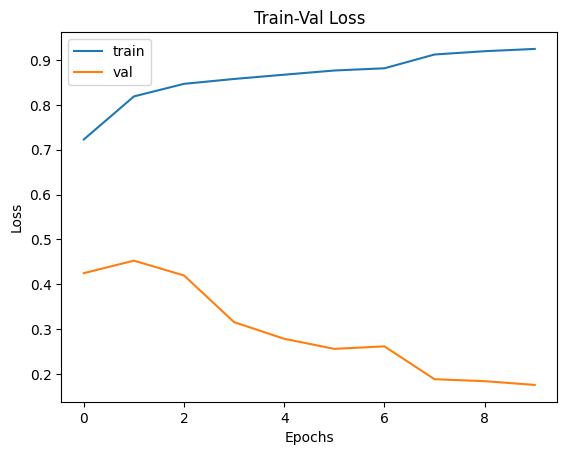

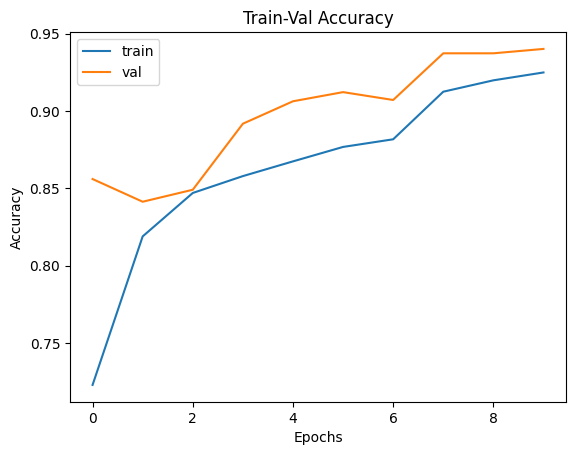

In [19]:
train_loss_history = loss_hist["train"] # 그래프로 표시해보자 
val_loss_history = loss_hist["val"]
train_acc_history = metric_hist["train"]
val_acc_history = metric_hist["val"]

train_acc_history = torch.stack(train_acc_history).cpu() # 리스트가 파이토치 텐서라 1차원 텐서로 바꿔주고 gpu 텐서는 넘파이 변환이 안되므로 cpu로..
val_acc_history =  torch.stack(val_acc_history).cpu()

plt.title("Train-Val Loss")
plt.plot(train_loss_history,label="train") # 여기 변수 잘못 넣었음..
plt.plot(val_loss_history,label="val")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(train_acc_history,label="train")
plt.plot(val_acc_history,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# 두번째 방식 

In [20]:
model_conv = torchvision.models.resnet34(pretrained=True) # 미세 조정, 마지막 계층을 제외한 신경망을 고정 후 다시 돌려보기
for param in model_conv.parameters():
    param.requires_grad = False # 매개변수 고정 후 경사도 계산 안하기(requires_grad 기본값은 True 이다다)

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len (class_names)) # 512, 6

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이번에는 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [21]:
model_conv, loss_hist, metric_hist = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10) #경사도 계산을 거의 안해도 되므로 시간이 거의 절반으로 줄어든다..그래도 순전파 계산은 해야함

Epoch 0/9
----------
train Loss: 1.1038 Accuracy: 0.6176
val Loss: 0.9301 Accuracy: 0.7187

Epoch 1/9
----------
train Loss: 1.0742 Accuracy: 0.6369
val Loss: 0.6554 Accuracy: 0.7779

Epoch 2/9
----------
train Loss: 1.0824 Accuracy: 0.6346
val Loss: 0.8188 Accuracy: 0.7462

Epoch 3/9
----------
train Loss: 1.0628 Accuracy: 0.6416
val Loss: 0.7657 Accuracy: 0.7540

Epoch 4/9
----------
train Loss: 1.0756 Accuracy: 0.6380
val Loss: 0.6518 Accuracy: 0.7819

Epoch 5/9
----------
train Loss: 1.0676 Accuracy: 0.6428
val Loss: 0.6846 Accuracy: 0.7730

Epoch 6/9
----------
train Loss: 1.0724 Accuracy: 0.6418
val Loss: 0.7485 Accuracy: 0.7515

Epoch 7/9
----------
train Loss: 0.8940 Accuracy: 0.6850
val Loss: 0.6566 Accuracy: 0.7762

Epoch 8/9
----------
train Loss: 0.8761 Accuracy: 0.6879
val Loss: 0.5834 Accuracy: 0.7994

Epoch 9/9
----------
train Loss: 0.8712 Accuracy: 0.6871
val Loss: 0.6066 Accuracy: 0.7892

Training complete in 56m 14s
Best val Accuracy: 0.799417


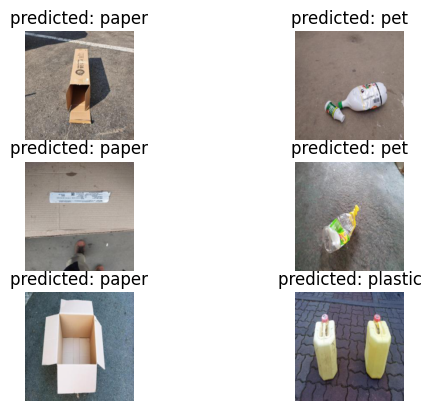

In [22]:
visualize_model(model_conv) # 새 예측값 시각화 

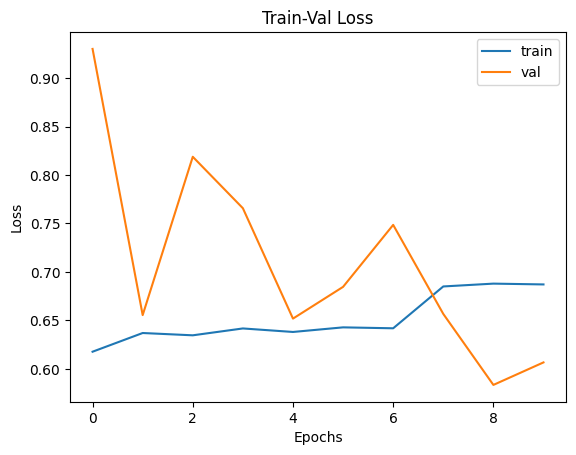

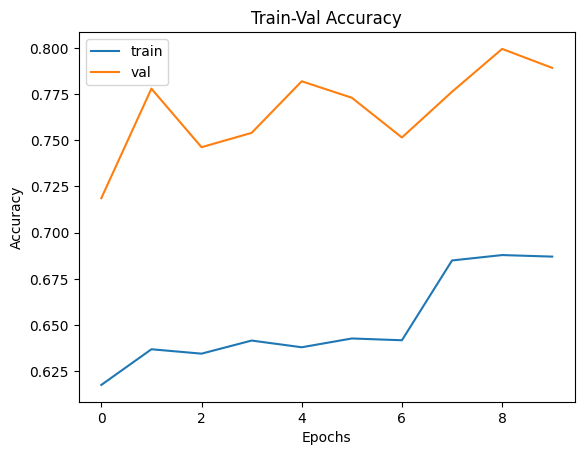

In [23]:
train_loss_history = loss_hist["train"] # 그래프로 표시해보자 
val_loss_history = loss_hist["val"]
train_acc_history = metric_hist["train"]
val_acc_history = metric_hist["val"]

train_acc_history = torch.stack(train_acc_history).cpu() # 리스트가 파이토치 텐서라 1차원 텐서로 바꿔주고 gpu 텐서는 넘파이 변환이 안되므로 cpu로..
val_acc_history =  torch.stack(val_acc_history).cpu()

plt.title("Train-Val Loss")
plt.plot(train_loss_history,label="train") # 변수 잘못 넣음...
plt.plot(val_loss_history,label="val")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(train_acc_history,label="train")
plt.plot(val_acc_history,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [24]:
model_path = os.path.join('/content/data_new', str('model_resnet34')+".pth") # 모델저장
torch.save(model_conv.state_dict(), model_path)